In [1]:
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = load_diabetes()
feature_names = ['age', 'sex', 'body_mass_index', 'blood_pressure', 'serum_cholesterol', 'ldl', 'hdl', 'cholesterol_ratio', 'triglycerides', 'blood_sugar']

In [3]:
df = pd.DataFrame(data.data, columns=feature_names)
df.isnull().sum()

age                  0
sex                  0
body_mass_index      0
blood_pressure       0
serum_cholesterol    0
ldl                  0
hdl                  0
cholesterol_ratio    0
triglycerides        0
blood_sugar          0
dtype: int64

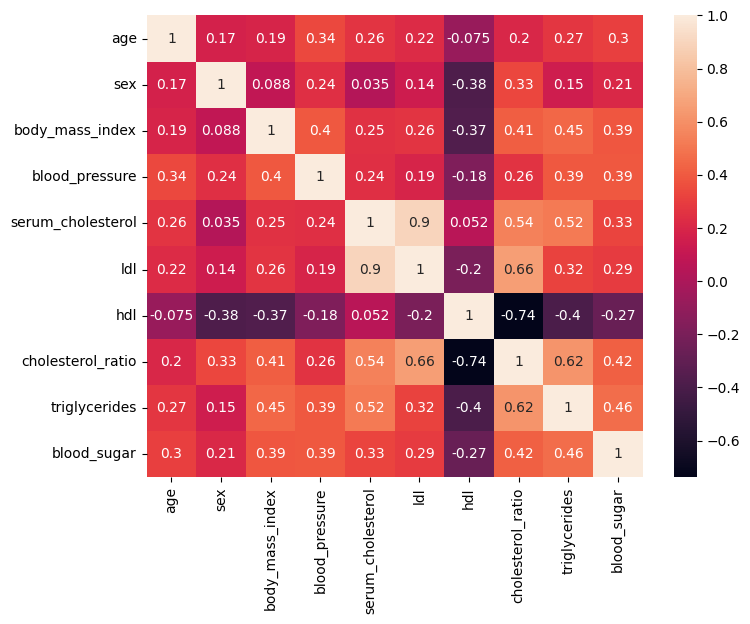

In [4]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [5]:
df.corr()[df.corr() < 1].unstack().transpose().sort_values(ascending=False).drop_duplicates()

ldl                serum_cholesterol    0.896663
                   cholesterol_ratio    0.659817
cholesterol_ratio  triglycerides        0.617859
serum_cholesterol  cholesterol_ratio    0.542207
                   triglycerides        0.515503
triglycerides      blood_sugar          0.464669
body_mass_index    triglycerides        0.446157
cholesterol_ratio  blood_sugar          0.417212
                   body_mass_index      0.413807
blood_pressure     body_mass_index      0.395411
                   triglycerides        0.393480
                   blood_sugar          0.390430
blood_sugar        body_mass_index      0.388680
age                blood_pressure       0.335428
cholesterol_ratio  sex                  0.332115
serum_cholesterol  blood_sugar          0.325717
ldl                triglycerides        0.318357
blood_sugar        age                  0.301731
ldl                blood_sugar          0.290600
age                triglycerides        0.270774
body_mass_index    l

In [6]:
vif_data = pd.DataFrame()
vif_data["feature"] = feature_names
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(data.feature_names))]
print(vif_data)

             feature        VIF
0                age   1.217307
1                sex   1.278071
2    body_mass_index   1.509437
3     blood_pressure   1.459428
4  serum_cholesterol  59.202510
5                ldl  39.193370
6                hdl  15.402156
7  cholesterol_ratio   8.890986
8      triglycerides  10.075967
9        blood_sugar   1.484623


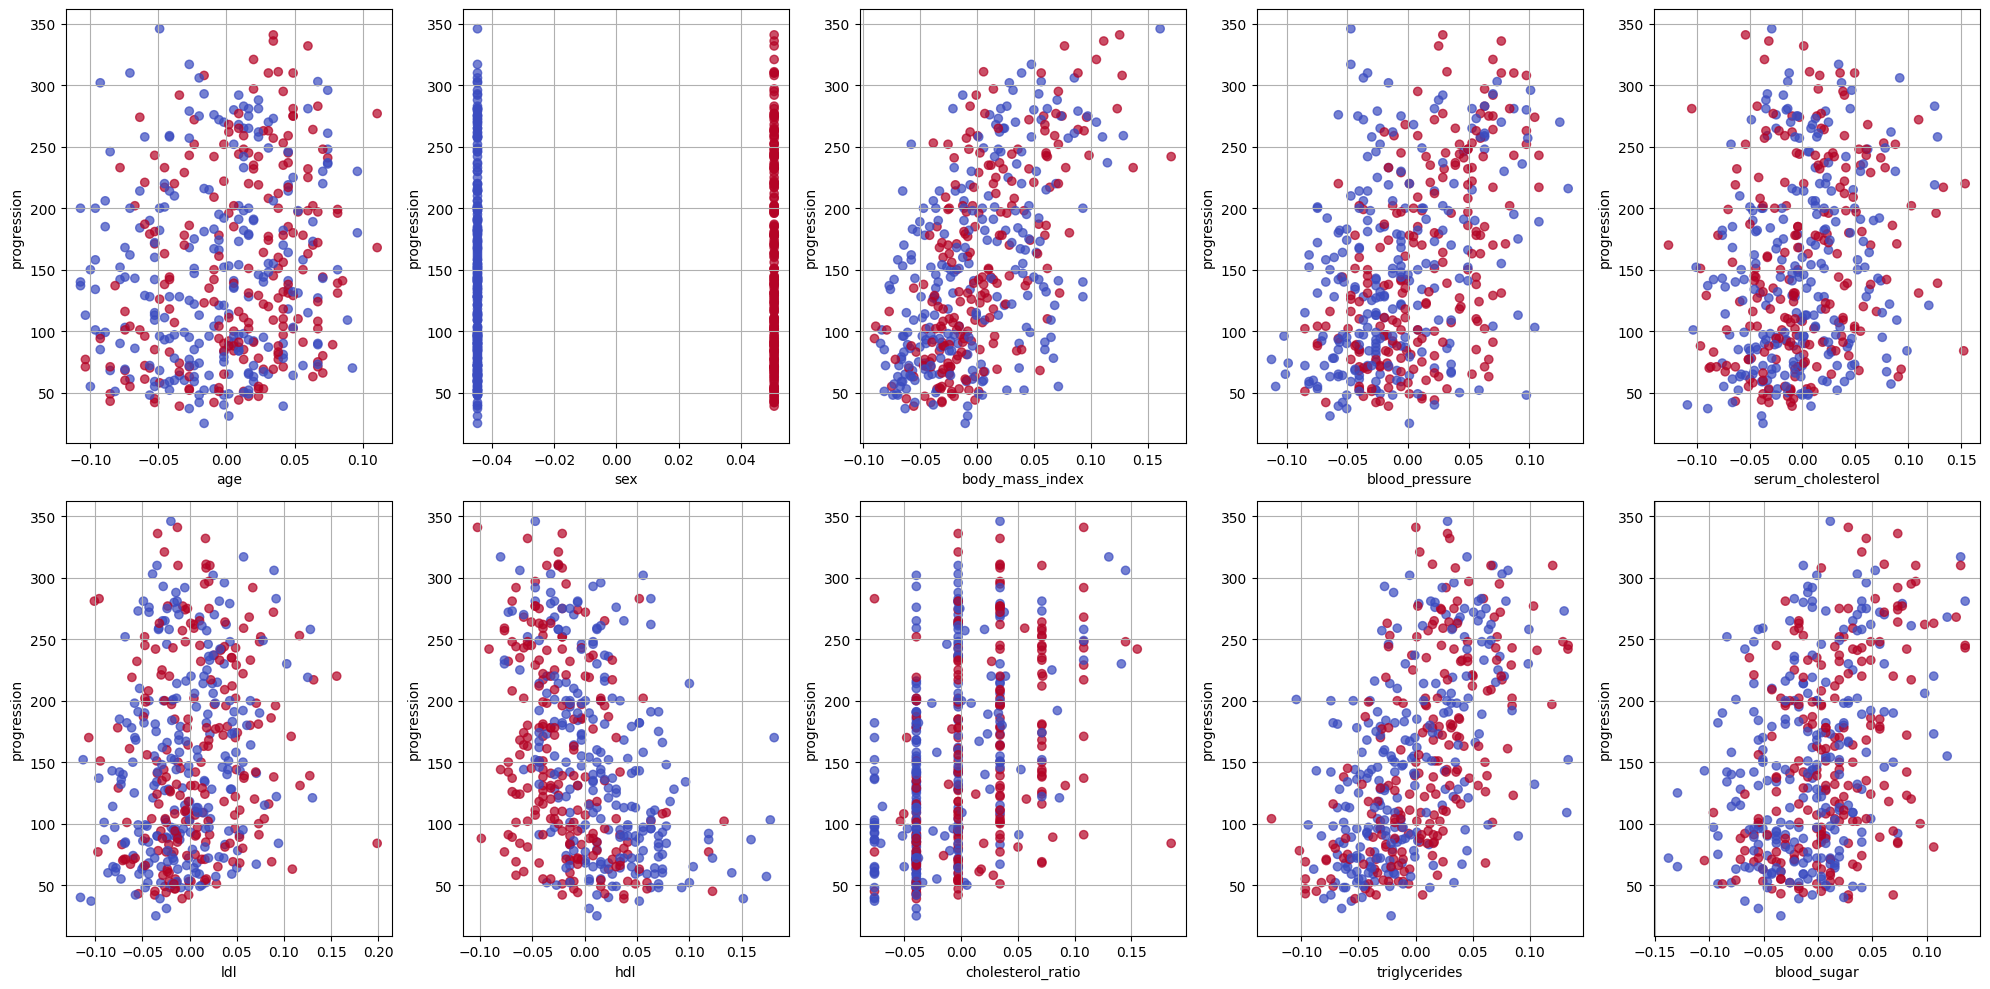

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))

for i, feature in enumerate(feature_names):
    # separate the data into colors by data.data[:,1] which consists of 0s and 1s, where 0 is female and 1 is male
    ax[i//5, i%5].scatter(data.data[:, i], data.target, c=data.data[:,1], alpha=0.7, cmap='coolwarm')
    ax[i//5, i%5].set_xlabel(feature)
    ax[i//5, i%5].set_ylabel('progression')
    ax[i//5, i%5].grid(True)

plt.tight_layout()
plt.show()

In [8]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(data.data)
scaled_X.shape

(442, 10)

In [9]:
epochs = 100_000
loss_history = list()
intercept_history = list()
coefficients_history = np.zeros((scaled_X.shape[1], epochs))

def predict(intercept: float, coefficient: list, data: list) -> list:
    return intercept + np.dot(data, coefficient)

def loss_function(coefficients, errors, regularization_term):
    return np.mean(np.square(errors)) + regularization_term * np.sum(np.square(coefficients))

def soft_threshold(rho, lambda_):
    if rho < -lambda_:
        return (rho + lambda_)
    elif rho > lambda_:
        return (rho - lambda_)
    else:
        return 0

def ridge_regression(x, y, epochs, learning_rate = 0.1, regularization_term = 0.01):
    intercept, coefficients = 0, np.zeros(x.shape[1])
    length = x.shape[0]

    intercept_history.append(intercept)
    coefficients_history[:, 0] = coefficients
    loss_history.append(loss_function(coefficients, y, regularization_term))

    for i in range(1, epochs):
        predictions = predict(intercept, coefficients, x)
        errors = predictions - y
        intercept = intercept - learning_rate * np.sum(errors) / length
        intercept_history.append(intercept)
        
        for j in range(len(coefficients)):
            gradient = np.dot(x[:, j], errors) / length
            temp_coef = coefficients[j] - learning_rate * gradient
            coefficients[j] = soft_threshold(temp_coef, regularization_term)
            coefficients_history[j, i] = coefficients[j]
        
        loss_history.append(loss_function(coefficients, errors, regularization_term))

    return intercept, coefficients

intercept, cofficients = ridge_regression(scaled_X, data.target, epochs)

In [10]:
print(f"loss: {loss_history[-1]}")
for coef, feature in zip(cofficients, data.feature_names):
    print(f"{feature}: {coef}")

loss: 2891.1156059740947
age: -0.27755227838178304
sex: -11.160779416174789
bmi: 24.853286360922823
bp: 15.2421071109894
s1: -26.47759336137202
s2: 13.75670764999165
s3: 0.0
s4: 7.043017537880728
s5: 31.588975454896946
s6: 3.1587959114435913


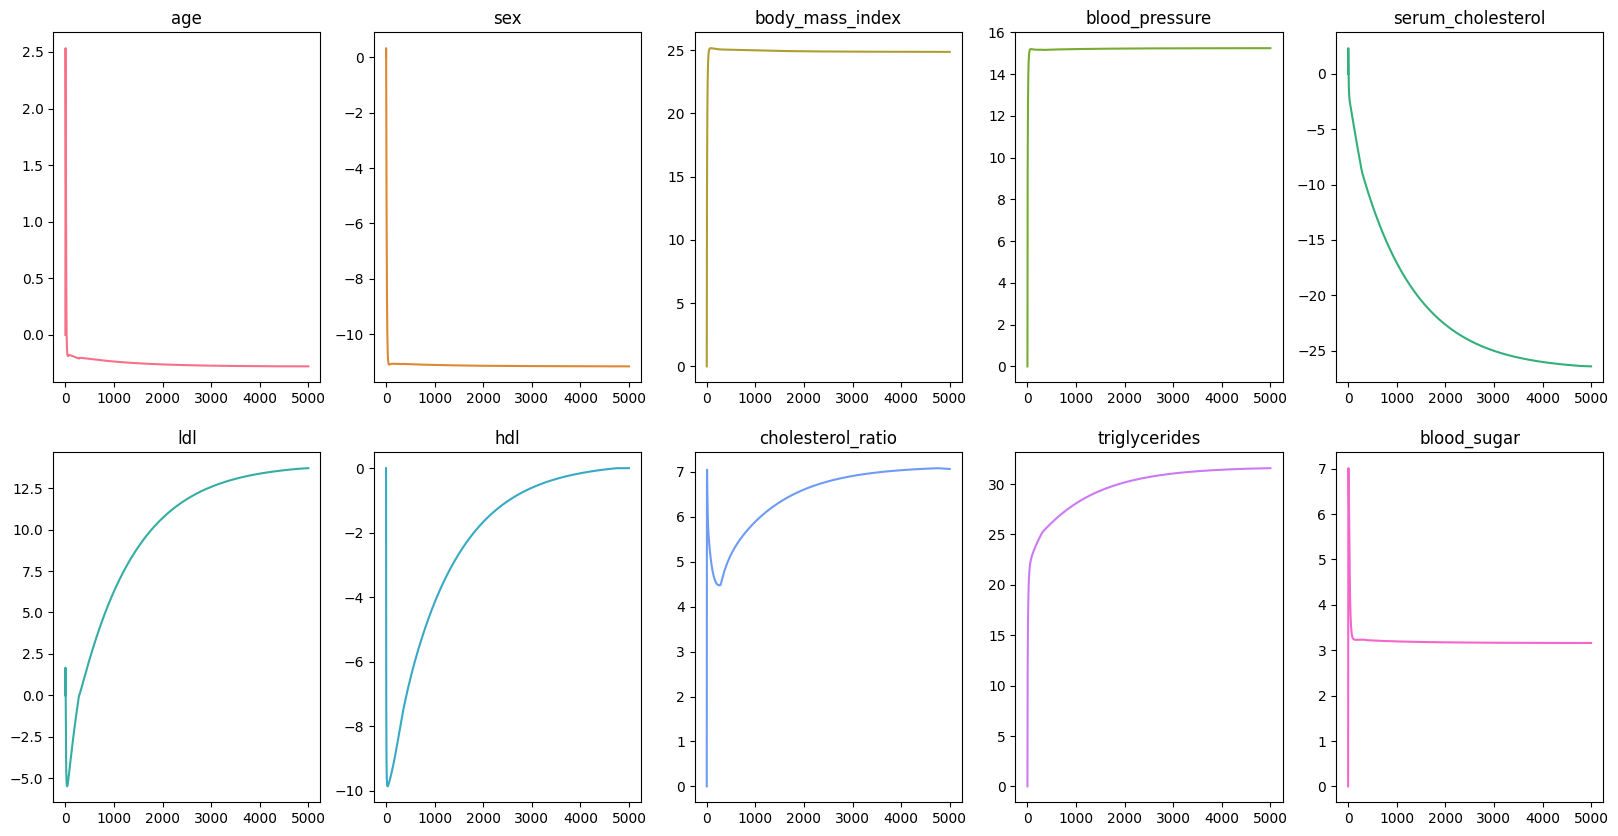

In [11]:
fix, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, color in zip(range(10), sns.color_palette("husl", 10)):
    ax[i//5, i%5].plot(coefficients_history[i,:5000], color=color)
    ax[i//5, i%5].set_title(feature_names[i])